## correcting nonuniform illumination

- [original discussion](http://www.mathworks.com/help/images/examples/correcting-nonuniform-illumination.html)
- background: binarization is usually the key to many problems, e.g., segmentations and labelling. It depends on a relatively uniform clustering of foreground and background illuminations. Challenges include noise, shadows and etc.
- this example illustrates common techniques to make the illumination more uniform in the image

In [1]:
%matplotlib inline

In [57]:
import matplotlib.pyplot as plt
from skimage import io, color, measure, morphology, filters, exposure
import scipy.ndimage as nd
import numpy as np

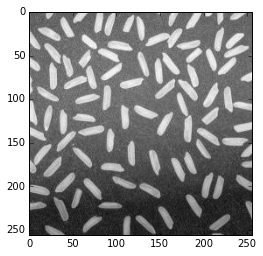

In [18]:
## load the image - load it from another source
## a closer look reveals that the background illumination is not uniform - darker at the bottom
## there is salt/pepper noise scattered as well
rice = io.imread("http://blogs.mathworks.com/images/steve/2008/transparency_example_1_01.jpg", as_grey=True)
plt.imshow(rice, cmap=plt.cm.gray)

So the goal is to estimate the distribution of areas of rice grains. To do that, the grains must be segmented and labelled

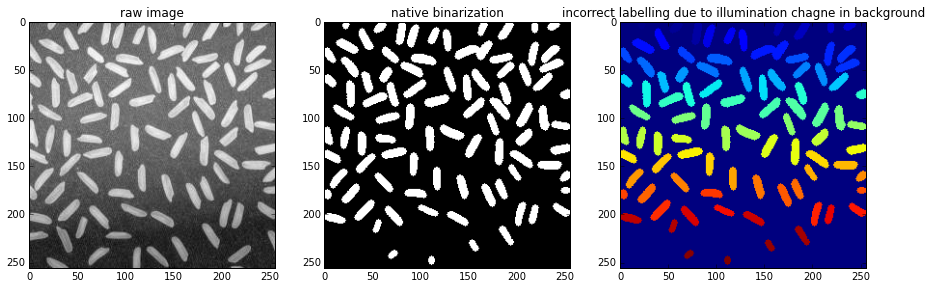

In [28]:
## without any illumination correction, first attempt
##smooth = filters.rank.median(rice, selem = morphology.disk(3))

bw = rice > filters.threshold_otsu(smooth)
bw = nd.binary_fill_holes(bw)
bw = morphology.binary_opening(bw, selem = morphology.disk(3))
bw = morphology.remove_small_objects(bw, min_size=5)
labels = measure.label(bw)

fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(rice, cmap = plt.cm.gray)
axes[0].set_title("raw image")
axes[1].imshow(bw, cmap = plt.cm.gray)
axes[1].set_title("native binarization")
axes[2].imshow(labels)
axes[2].set_title("incorrect labelling due to illumination chagne in background")

## suggested steps from the article
1. Use morphological opening to estimate the background (morphological.opening or morphological.white_tophat)
2. substract the background to get relatively uniform illumination
3. increase the image contrast by histogram adjusting - image is ready for normal segmentation
4. binarization, segmentation, labelling, analysis

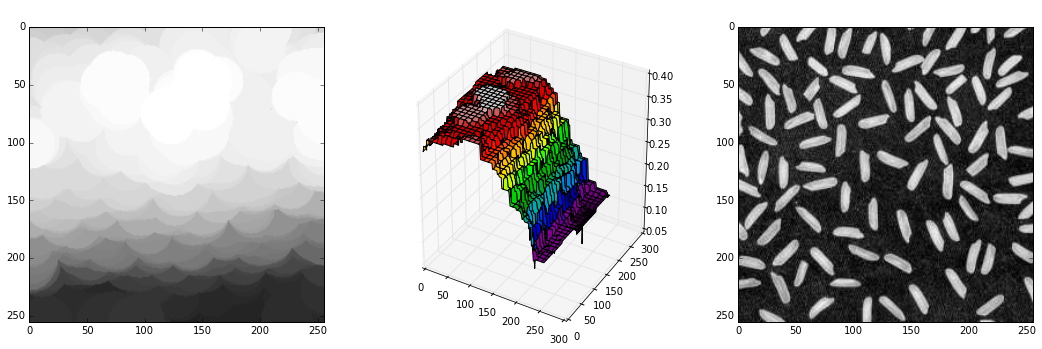

In [52]:
## 1. estimate image background by morphology.opening (with large structural element)

background = morphology.opening(rice, selem = morphology.disk(21))
rows, cols = np.meshgrid(range(0, background.shape[0], 1), range(0, background.shape[1], 1))
fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot(131)
ax.imshow(background, cmap = plt.cm.gray)
ax = fig.add_subplot(132, projection="3d")
ax.plot_surface(rows, cols, background[rows, cols], cmap = plt.cm.spectral)
ax = fig.add_subplot(133)
adjusted = rice-background
ax.imshow(adjusted, cmap = plt.cm.gray)

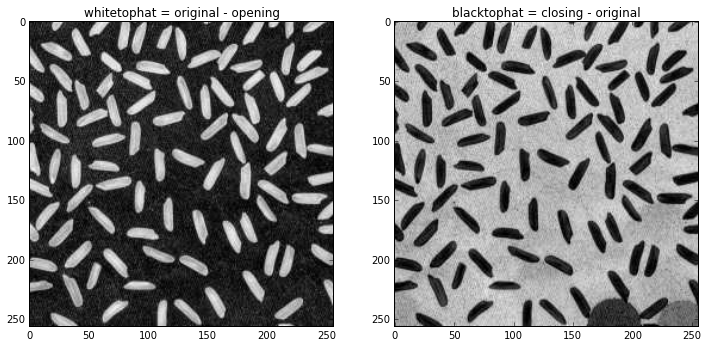

In [56]:
## 1. alternativelly estimate image background by morphology.tophat
## white_tophat = original - opening image
## black_tophat = closing image - original
adjusted = morphology.white_tophat(rice, selem = morphology.disk(21))
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
axes[0].imshow(adjusted, cmap = plt.cm.gray)
axes[0].set_title("whitetophat = original - opening")
axes[1].imshow(morphology.black_tophat(rice, selem = morphology.disk(21)), cmap = plt.cm.gray)
axes[1].set_title("blacktophat = closing - original")

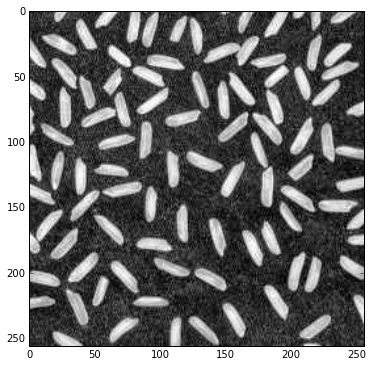

In [62]:
## 2. make the contrast better - optional
contrasted = exposure.equalize_adapthist(adjusted,)
plt.figure(figsize = (6, 6))
plt.imshow(contrasted, cmap = plt.cm.gray)

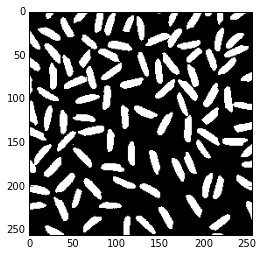

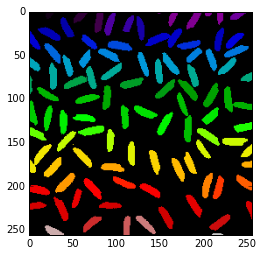

In [70]:
## 3. binarize and label
bw = adjusted > filters.threshold_otsu(adjusted)
plt.imshow(bw, cmap = plt.cm.gray)
labels = measure.label(bw)
plt.figure()
plt.imshow(labels, cmap = plt.cm.spectral)

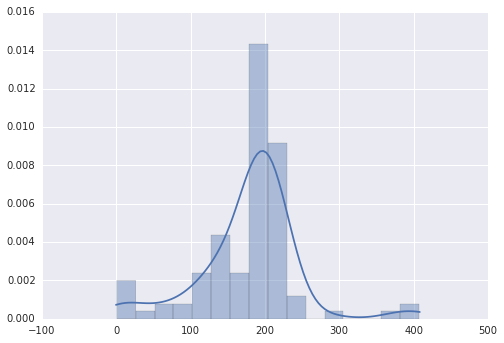

In [72]:
## calculate region areas
import seaborn as sb
areas = [r.area for r in measure.regionprops(labels)]
_ = sb.distplot(areas)